In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import math
import logging
import numpy as np
import seaborn as sns
import index_definition
import index_utils as ai
from confidence_index import get_index_cut_by_time
from train_online_model import predict, generate_live_match_data
import warnings
import common
import dill
import confidence_index as ci
import feature_utils
# 忽略所有警告
warnings.filterwarnings("ignore")
# logging.basicConfig(
#     level=logging.INFO,  
#     format='%(asctime)s [简记] %(message)s',  # 去除非必要字段
#     handlers=[
#         logging.StreamHandler(), 
#         logging.FileHandler('data_analysis.log') 
#     ]
# )

data = pd.read_csv("Linhac24-25_Sportlogiq.csv")
data['inopponentarea'] = data.apply(common.puck_location, axis=1)
gameids = data['gameid'].unique()

In [ ]:
 #探究信心指数对比赛结果的影响
# gameids = gameids[0:4]
# team_feature_df = get_index_cut_by_time(data, gameids, index_definition.CONFIDENCE_INDEX, 120, tfrom=0, to=3600)
# max_cols = 2  #每行最多显示2张
# num_plots = len(gameids) * 2
# rows = (num_plots + max_cols - 1) // max_cols
# cols = min(max_cols, num_plots)
# plt.figure(figsize=(15, rows * 3))
# sns.set_theme(style="dark")
# 
# for i in range(len(gameids)):
#     gameid = gameids[i]
#     j = i * 2 if i > 0 else 0
#     winner = common.get_winner(data, gameid)
#     winnerid = winner[0]
#     loserid = winner[1]
#     winner_df = team_feature_df[(team_feature_df['gameid'] == gameid) & (team_feature_df['teamid'] == winnerid)]
#     winner_goal = winner_df[winner_df['goal'] == 1]['elapsed_sec'].values
#     loser_df = team_feature_df[(team_feature_df['gameid'] == gameid) & (team_feature_df['teamid'] == loserid)]
#     loser_goal = loser_df[loser_df['goal'] == 1]['elapsed_sec'].values
#     feature_names = ['accuracy_reception_succ', 'accuracy_pass_succ', 'efficient_block_succ', 'body_check']
#     colors = sns.color_palette("bright", n_colors=len(feature_names))
#     ax = plt.subplot(rows, cols, j + 1)
#     ax0 = plt.subplot(rows, cols, j + 2)
#     for c, (f, color) in enumerate(zip(feature_names, colors)):
#         sns.lineplot( x=list(winner_df['elapsed_sec']),y=list(winner_df[f]), color=color, label=f, ax=ax)
#         ax.set_title('Game:' + str(gameid) + 'WinnerTeamid:' + str(winnerid))
#         # sns.lineplot( x=list(loser_df['elapsed_sec']), y=list(loser_df[f]),color=color, label=f, ax=ax0)
#         # ax0.set_title('Game:' + str(gameid) + 'LoseTeamid:' + str(loserid))
#         for goal_time in winner_goal:
#             ax.vlines(x=goal_time, ymin=0, ymax=ax.get_ylim()[1], color='green', linestyles='-')
#         # for goal_time in loser_goal:
#         #     ax0.vlines(x=goal_time, ymin=0, ymax=ax0.get_ylim()[1], color='green', linestyles='-')
#     for c, (f, color) in enumerate(zip(feature_names, colors)):
#         # sns.lineplot( x=list(winner_df['elapsed_sec']),y=list(winner_df[f]), color=color, label=f, ax=ax)
#         # ax.set_title('Game:' + str(gameid) + 'WinnerTeamid:' + str(winnerid))
#         sns.lineplot( x=list(loser_df['elapsed_sec']), y=list(loser_df[f]),color=color, label=f, ax=ax0)
#         ax0.set_title('Game:' + str(gameid) + 'LoseTeamid:' + str(loserid))
#         # for goal_time in winner_goal:
#         #     ax.vlines(x=goal_time, ymin=0, ymax=ax.get_ylim()[1], color='green', linestyles='-')
#         for goal_time in loser_goal:
#             ax0.vlines(x=goal_time, ymin=0, ymax=ax0.get_ylim()[1], color='green', linestyles='-')
# plt.tight_layout()
# plt.legend()
# plt.show()

In [ ]:
## 研究第一节比赛数据是否能预测最后的比赛结果

#所有比赛的整体数据分析
events = {**index_definition.CONTEST,**index_definition.GOAL, **index_definition.PASS, **index_definition.SHOT, **index_definition.BLOCK,**index_definition.CHECK, }
max_cols = 2  #每行最多显示2张
num_plots = len(events) 
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
normal_time_df = data[(data['compiledgametime'] <= 3600)]
for index, (event_name, event) in enumerate(events.items()):
    ax = plt.subplot(rows, cols, index+1)
    condition = normal_time_df.eval(event)
    event_df = normal_time_df[condition]
    bin_inter = 180
    bins = list(np.arange(0, 3600, bin_inter))
    bins.append(3600)
    labels = bins[0:20]
    event_df['cut'] = pd.cut(event_df['compiledgametime'], bins=bins, labels=labels)
    sns.countplot(x='cut', hue='eventname', data=event_df,ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(event_name)
    ax.set_xlabel('Time')
    ax.set_ylabel(event_name + ' Number')
    ax.legend(title=event_name)


plt.tight_layout()
# 显示图表
plt.show()

In [ ]:
#比赛0到540秒,即前9分钟,相比较与其他时间段进球的队伍，首先进球队伍的胜率非常低，只有48%，输掉比赛的概率有41%，
# 其他时间段内普遍在60%以上，其中在后半场开场后一段时间内，进球队伍胜率最高，达到了70%以上
start_time = 0
end_time =  600
total_games = 0
first_goal_win_teams = 0
first_goal_home_win_teams = 0
first_goal_win_tie_teams =0
first_goal_lost_teams = 0
special_time_df =  data[(data['compiledgametime'] <= end_time) & (data['compiledgametime'] >= start_time) & (data['eventname'] == 'goal')]
grouped = special_time_df.groupby('gameid')
for gameid, gamedata in grouped:
    total_games += 1
    winner = common.get_winner(data, gameid)
    home_team_id = common.get_home_team_id(data, gameid)
    goal_team = gamedata['teaminpossession'].unique()
    #如果这个时间段两个队伍都进球了，只计算第一个进球的队伍
    if len(goal_team) == 2:
        goal_team = gamedata.iloc[0]['teaminpossession']
    else:
        goal_team =gamedata['teaminpossession'].unique()[0]
    if goal_team == winner[0]: #至少比赛是平局
        first_goal_win_tie_teams += 1
        if  winner[2] is True: #比赛不是平局
            first_goal_win_teams += 1
            if winner[0] == home_team_id:
                first_goal_home_win_teams += 1
    else:
        first_goal_lost_teams += 1
print('总比赛场次:', total_games,',至少平局场次:', first_goal_win_tie_teams, ',赢下比赛场次:', first_goal_win_teams, '输掉比赛场次:', first_goal_lost_teams)
print('至少平局的概率:', first_goal_win_tie_teams / total_games)
print('赢下比赛的概率:', first_goal_win_teams / total_games)
print('是主队且赢下比赛的概率:', first_goal_home_win_teams / total_games)
print('输掉比赛的概率:', first_goal_lost_teams / total_games)


#探究控所有比赛主队和客队的球率
#发现主队在开场9分钟内控球率最高，客队在开场9分钟内控球率最低，结合上面的分析，可以看出主队在开场9分钟内控球率高，如果进球,赢球的概率却最低.



In [ ]:
##探究控所有比赛主队和客队的球率
#发现主队在开场9分钟内控球率最高，客队在开场9分钟内控球率最低，结合上面的分析，可以看出主队在开场9分钟内控球率高，如果进球,赢球的概率却最低.
bin_inter = 90
plt.figure(figsize=(10, 3))
bin_number = int(3600 / bin_inter)
unique_gameids = data['gameid'].unique()
gameids = unique_gameids[0:156]
home_total_control_times = [0] * bin_number
visit_total_control_times = [0] * bin_number
home_total_control_rates = [0] * bin_number
visit_total_control_rates = [0] * bin_number
game_first_period_control_rate= {}
game_all_period_control_times= {}
#按队伍计算每个时间段的控球率
game_total_control_rates = {}
for gameid in gameids:
    gamedata = data[(data['gameid'] == gameid)]
    game_home_total_control_times = [0] * bin_number
    game_visit_total_control_times = [0] * bin_number
    bins = list(np.arange(0, 3600, bin_inter))
    bins.append(3600)
    for i in range(len(bins)):
        if i + 1 == len(bins):
            game_first_period_control_rate[gameid] = game_home_total_control_times[0] / (
                        game_home_total_control_times[0] + game_visit_total_control_times[0])
            game_total_control_rates[gameid] = sum(game_home_total_control_times) / (
                        sum(game_home_total_control_times) + sum(game_visit_total_control_times))
            game_all_period_control_times[gameid]= [game_home_total_control_times, game_visit_total_control_times]
            break
        tfrom = bins[i]
        to = bins[i + 1]
        home_control_rate, visit_control_rate, home_possession_time, visit_possession_time = common.get_control_rate0(
            data, gameid, tfrom, to)
        home_total_control_times[i] = sum(home_possession_time) + home_total_control_times[i]
        visit_total_control_times[i] = sum(visit_possession_time) + visit_total_control_times[i]
        home_total_control_rates[i] = home_total_control_times[i] / (
                    home_total_control_times[i] + visit_total_control_times[i])
        visit_total_control_rates[i] = visit_total_control_times[i] / (
                    home_total_control_times[i] + visit_total_control_times[i])
        game_home_total_control_times[i] = sum(home_possession_time) 
        game_visit_total_control_times[i] = sum(visit_possession_time) 
plt.title('Home team puck control rate')
sns.lineplot(x=bins[1:], y=home_total_control_rates, color='r', label='Home Team')
sns.lineplot(x=bins[1:], y=visit_total_control_rates, color='b', label='Visit Team')
plt.legend()
plt.show()


In [ ]:
# 控球率与比赛结果的关系，按时间和比赛计算

max_cols = 2  #每行最多显示2张
num_plots = 20
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
sns.set_theme(style="dark")
for index, (gameid, game_control_times) in enumerate(game_all_period_control_times.items()):
    if index == num_plots - 1 : break
    home_control_times = game_control_times[0]
    visit_control_times = game_control_times[1]
    winner = common.get_winner(data, gameid)
    home_team_id = common.get_home_team_id(data,gameid)
    winnerid = winner[0]
    loserid = winner[1]
    ax = plt.subplot(rows, cols, index + 1)
    sns.lineplot(x=bins[1:], y=home_control_times, color='r', label='Home Team', ax=ax)
    title = 'Game:' + str(gameid) + ',Winner=Home Team'  if winnerid == home_team_id else 'Game:' + str(gameid) + ',Winner=Visit Team'
    if winner[2] is False:
        ax.set_title('Game:' + str(gameid) + ',Winner=Home Team(Tie)')
    else:
        ax.set_title(title)
    # ax0 = plt.subplot(rows, cols, index * 2 + 2)
    sns.lineplot(x=bins[1:], y=visit_control_times, color='b', label='Visit Team', ax=ax)
    # ax.set_title('Game:' + str(gameid) + 'LoseTeamid:' + str(loserid))
plt.legend()
plt.tight_layout()
# 显示图表
plt.show()



In [ ]:

#所以，我们有个猜想，第一节耗能最多的球队，反而最后会输掉比赛
#耗能的event数量太多，不一一分析，这里只分析一个event，即body_check
#检查第一节Body check和胜率的关系
grouped = data.groupby('gameid')
gameids = unique_gameids.tolist()
detail_df = ci.get_index_cut_by_time(data, gameids, {**index_definition.BODY, **index_definition.CONTEST},
                                    time_interval=180)
#计算前9分钟body的次数，以及比赛的结果
detail_df = detail_df[(detail_df['elapsed_sec'] <= 1200) & (detail_df['elapsed_sec'] >= 540)]
game_check_dict = {}
more_body_win = 0
less_body_win = 0
tie = 0
other = 0
for gameid in gameids:
    game_df = detail_df[detail_df['gameid'] == gameid]
    team_ids = game_df['teamid'].unique().tolist()
    game_check_dict[gameid] = {}
    for teamid in team_ids:
        team_df = game_df[game_df['teamid'] == teamid]
        body_event_sum = team_df['contest'].sum()
        game_check_dict[gameid][teamid] = body_event_sum

for gameid, value in game_check_dict.items():
    winner = common.get_winner(data, gameid)
    home_team_id = common.get_home_team_id(data, gameid)
    teamids = list(value.keys())
    body_sums = list(value.values())
    if body_sums[0] > body_sums[1]:
        if winner[0] == teamids[0] and winner[2] is True:
            more_body_win += 1
        elif winner[0] == teamids[1] and winner[2] is True:
            less_body_win += 1
        elif winner[2] is False:
            tie += 1
    elif body_sums[0] < body_sums[1]:
        if winner[0] == teamids[0] and winner[2] is True:
            less_body_win += 1
        elif winner[0] == teamids[1] and winner[2] is True:
            more_body_win += 1
        elif winner[2] is False:
            tie += 1
print("其他情况数量:" + str(other))
print("平局数量:" + str(tie))
print("第一节更少的body check的队伍赢得比赛数量:" + str(less_body_win))
print("第一节更多的body check的队伍赢得比赛数量:" + str(more_body_win))
print("第一节更少的body check的队伍赢得比赛的概率是：" + str(less_body_win / len(gameids)))
print("第一节更多的body check的队伍赢得比赛的概率是：" + str(more_body_win / len(gameids)))



In [2]:
data = pd.read_csv("Linhac24-25_Sportlogiq.csv")
data['inopponentarea'] = data.apply(common.puck_location, axis=1)
unique_gameids = data['gameid'].unique()
gameids = unique_gameids.tolist()

In [3]:
#整理数据，提取特征
#包括两大类，一类是会影响体力的要素，一类是会影响信心指数的要素，两者也有重合的部分，比如成功的扑救会提高信心，但是会降低守门员的体力
#这里我暂时把SAVE这个动作放入影响体力要素里面

#两种抽取特征方法,一场比赛抽取两次特征，主队一次，客队一次
#或者一场比赛抽取一次特征，主客特征相对值

all_events_index = {**index_definition.EXERTION_INDEX, **index_definition.CONFIDENCE_INDEX}
#将第一节时间也分成两个部分,一个是0到540秒，一个是540到1200秒

first_period_index_df1 =ci.get_index_cut_by_time(data, gameids, all_events_index, 180,tfrom = 0, to = 540)
first_period_index_df2 =ci.get_index_cut_by_time(data, gameids, all_events_index, 180,tfrom = 540, to = 1200)
first_period_index_df3 =ci.get_index_cut_by_time(data, gameids, all_events_index, 180,tfrom = 1200, to = 1800)
first_period_index_df4 =ci.get_index_cut_by_time(data, gameids, all_events_index, 180,tfrom = 1800, to = 2400)



# res1 = feature_utils.extract_features(data,first_period_index_df1,"_p1", all_events_index, 0, 540)
# res2 = feature_utils.extract_features(data,first_period_index_df2, "_p2",all_events_index, 540, 1200)
# 
# res3 = feature_utils.extract_features(data,first_period_index_df3,"_p3", all_events_index, 1200, 1800)
# res4 = feature_utils.extract_features(data , first_period_index_df4,"_p4", all_events_index, 1800, 2400)


res1 = feature_utils.extract_relative_features(data,first_period_index_df1,"_p1", all_events_index, 0, 540)
res2 = feature_utils.extract_relative_features(data,first_period_index_df2, "_p2",all_events_index, 540, 1200)

# res3 = feature_utils.extract_relative_features(data,first_period_index_df3,"_p3", all_events_index, 1200, 1800)
# res4 = feature_utils.extract_relative_features(data , first_period_index_df4,"_p4", all_events_index, 1800, 2400)

res1.drop(columns=['win'],inplace=True)
#merge_res = res1.merge(res2, on= ['gameid','teamid','is_home'], how='left')
merge_res = res1.merge(res2, on= ['gameid'], how='left')
#merge_res.rename(columns={'win_p2':'win'},inplace=True)
merge_res.drop(columns =['gameid'],inplace=True,errors='ignore')


# res3.drop(columns=['win_p3'],inplace=True)
# merge_res1 = res3.merge(res4, on= ['gameid','teamid','is_home'], how='left')
# merge_res1.rename(columns={'win_p4':'win'},inplace=True)
# merge_res1.drop(columns =['gameid','teamid'],inplace=True)





🚀 Processing: 7674it [00:21, 360.12it/s]                       0.23it/s]
🚀 Processing: 7674it [00:28, 265.97it/s]                       6.62it/s]
🚀 Processing: 7674it [00:29, 263.66it/s]                       5.63it/s]
🚀 Processing: 7674it [00:29, 263.68it/s]                       5.93it/s]


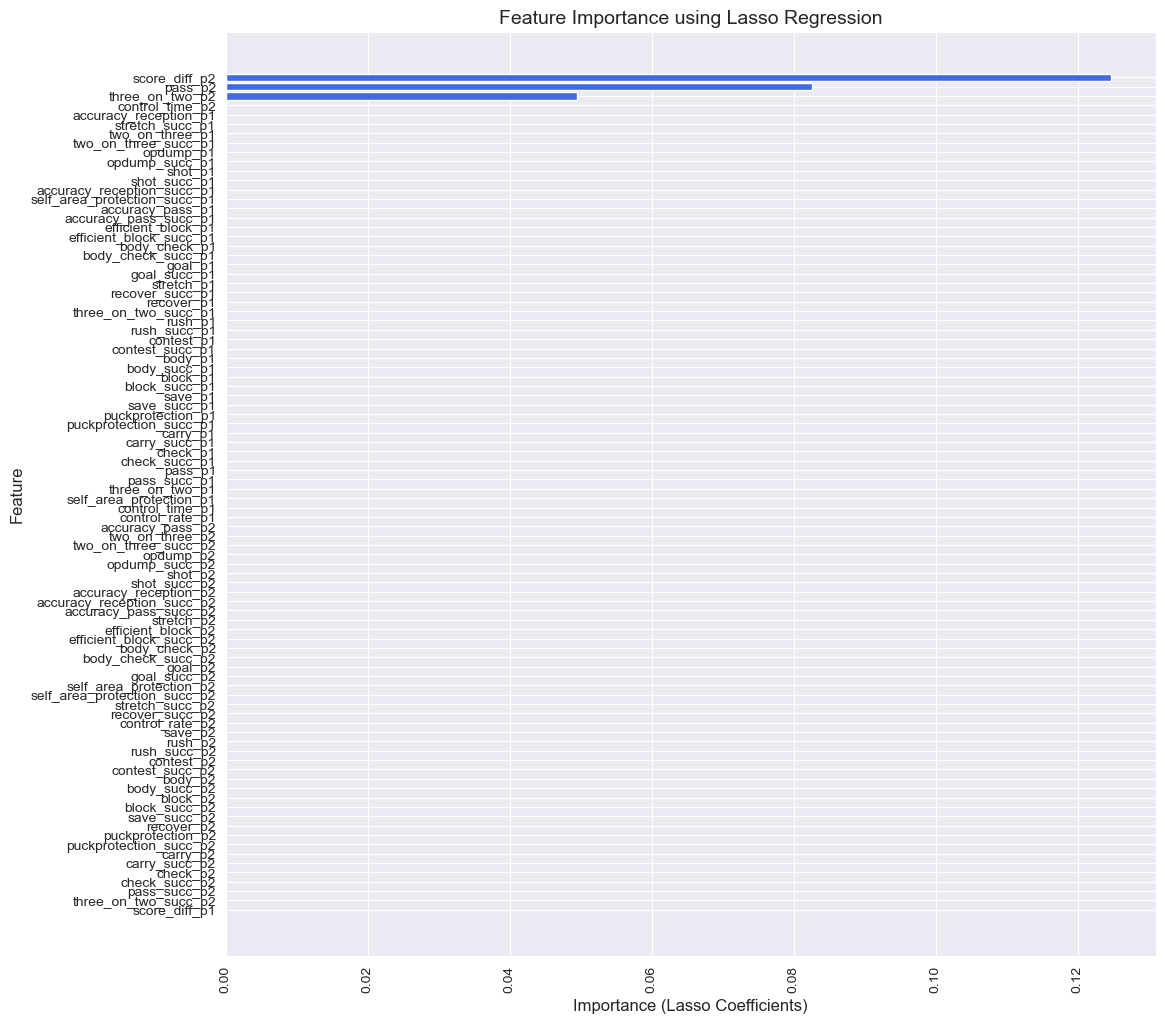

✅ Accuracy: 0.5957
⚡ F1-Score (Weighted): 0.5912


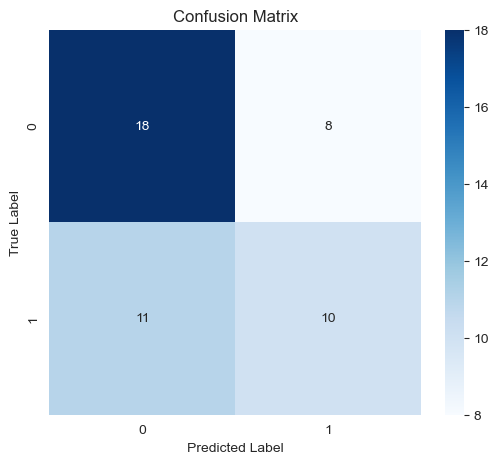

In [4]:
#使用多种机器学习模型进行训练
#首先使用lasso进行特征选择
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from boruta import BorutaPy
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
#拿第一阶段的数据作预测
X = merge_res.drop(columns=['win'],inplace=False)
y = merge_res['win']
#拿第二阶段的数据作预测
# X = merge_res1.iloc[:,:-1]
# y = merge_res1['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. 训练 Lasso 回归模型
#lasso = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=0.1)
lasso = LogisticRegression(
    penalty='l1',        # L1正则化(Lasso)
    solver='liblinear',  # 专门优化二分类问题的求解器
    C=0.1,               # 正则化强度（更小值=更强正则化）
    random_state=42
)
lasso.fit(X_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

# 4. 获取特征重要性（Lasso 回归的系数）
# 获取 Lasso 的特征系数
feature_importance = np.abs(lasso.coef_).sum(axis=0)  # 对 OvR 分类器求和
feature_names = X.columns  # 获取特征名称

# 按重要性排序
sorted_idx = np.argsort(feature_importance)[::-1] 
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importance = feature_importance[sorted_idx]
# sorted_indices = np.argsort(feature_importance)[::-1]  # 按重要性降序排序
# sorted_features = X.columns[sorted_indices]
# sorted_importance = feature_importance[sorted_indices]


# 5. 可视化特征重要性
plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_importance)), sorted_importance, tick_label=sorted_features, color='royalblue')
plt.xlabel("Importance (Lasso Coefficients)", fontsize=12)
plt.xticks(rotation=90)
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Importance using Lasso Regression", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)  # 缩小特征名称字体
plt.gca().invert_yaxis()  # 让重要特征排在上面
plt.show()

# 6. 打印最重要的特征
# important_features = np.where(feature_importance > 0)[0]
# print(f"重要特征索引: {sorted_importance}")
# print(f"对应的 Lasso 重要性系数: {lasso.coef_[sorted_importance]}")
# 计算准确率 & F1-score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# 输出评估指标
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"⚡ F1-Score (Weighted): {f1:.4f}")

# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_test.astype(int), y_pred.astype(int))
labels = np.unique(y_test)  # 确保只显示真实存在的类别

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



✅ 模型评估结果:
🎯 Accuracy: 0.4681
📈 AUC: 0.4579
⚡ F1-Score: 0.4691


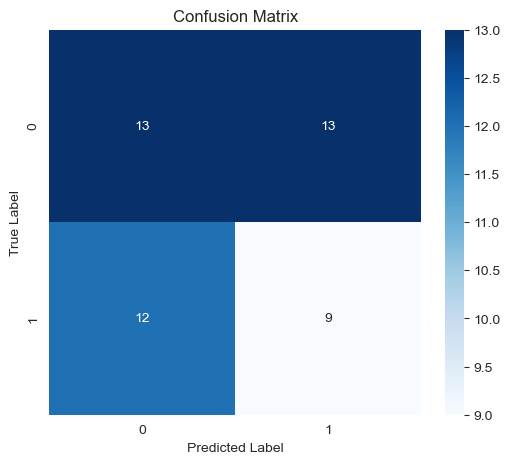

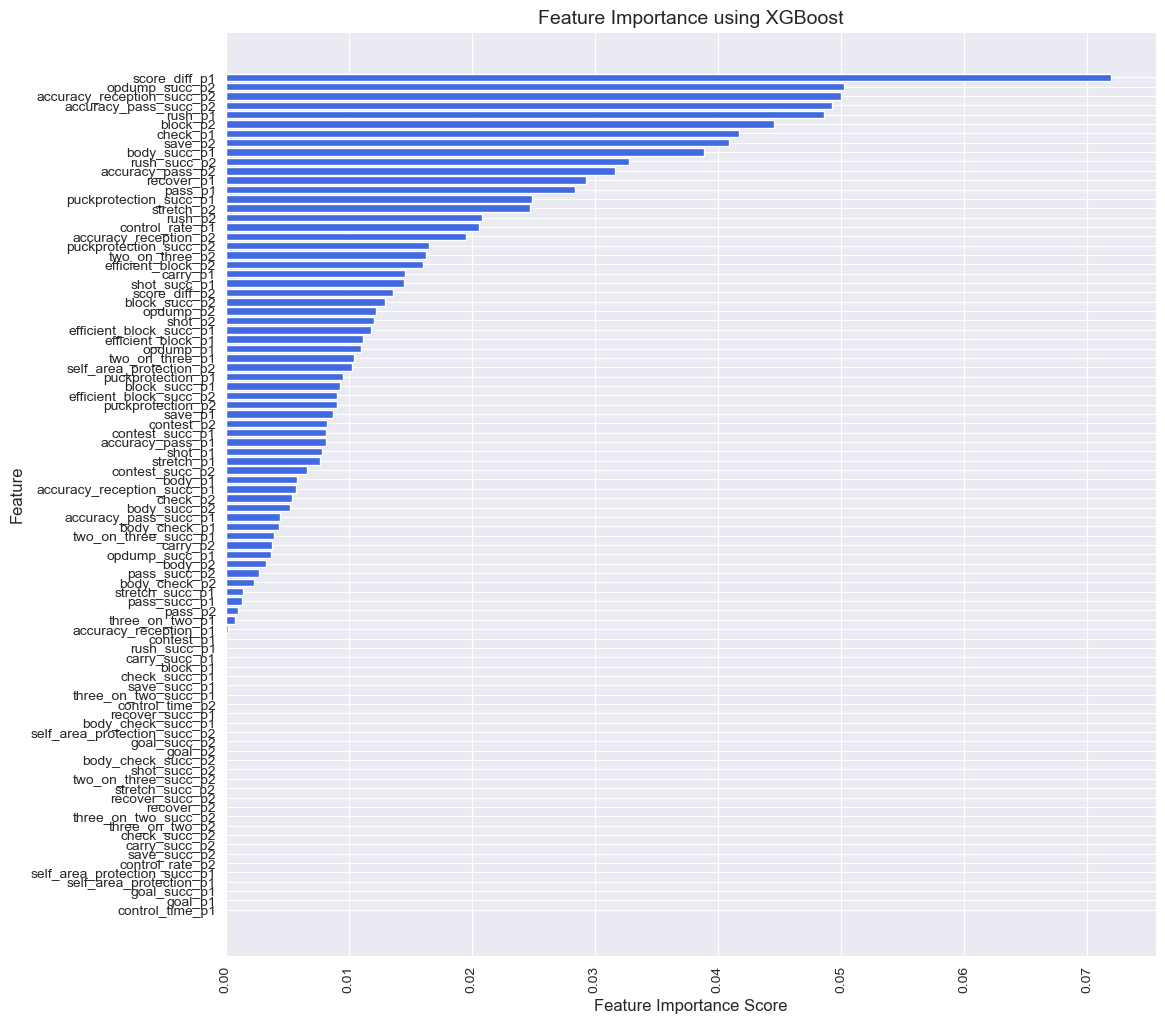

In [5]:
# model = xgb.XGBClassifier(objective="multi:softmax",nclass=2,n_estimators=100, random_state=42,
#                           eval_metric="mlogloss", use_label_encoder=False)

model = xgb.XGBClassifier(
    objective="binary:logistic",  # 二分类任务
    n_estimators=100, 
    random_state=42,
    eval_metric="logloss"  # 适用于二分类
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)  # 计算 AUC 用
acc = accuracy_score(y_test, y_pred)
#auc = roc_auc_score(y_test, y_prob,multi_class="ovr")
auc = roc_auc_score(y_test, y_prob[:, 1])

f1 = f1_score(y_test, y_pred,average="weighted")

print(f"✅ 模型评估结果:")
print(f"🎯 Accuracy: {acc:.4f}")
print(f"📈 AUC: {auc:.4f}")
print(f"⚡ F1-Score: {f1:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
importance = model.feature_importances_

sorted_indices = np.argsort(importance)[::-1]  # 按重要性降序排序
sorted_features = X.columns[sorted_indices]
sorted_importance = importance[sorted_indices]


plt.figure(figsize=(12, 12))
plt.barh(sorted_features, sorted_importance, color="royalblue")
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(rotation=90)
plt.title("Feature Importance using XGBoost", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()  # 让重要特征排在上方
plt.show()


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	84
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	84
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	84
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	84
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	87
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	87
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	87
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	87
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	88
I

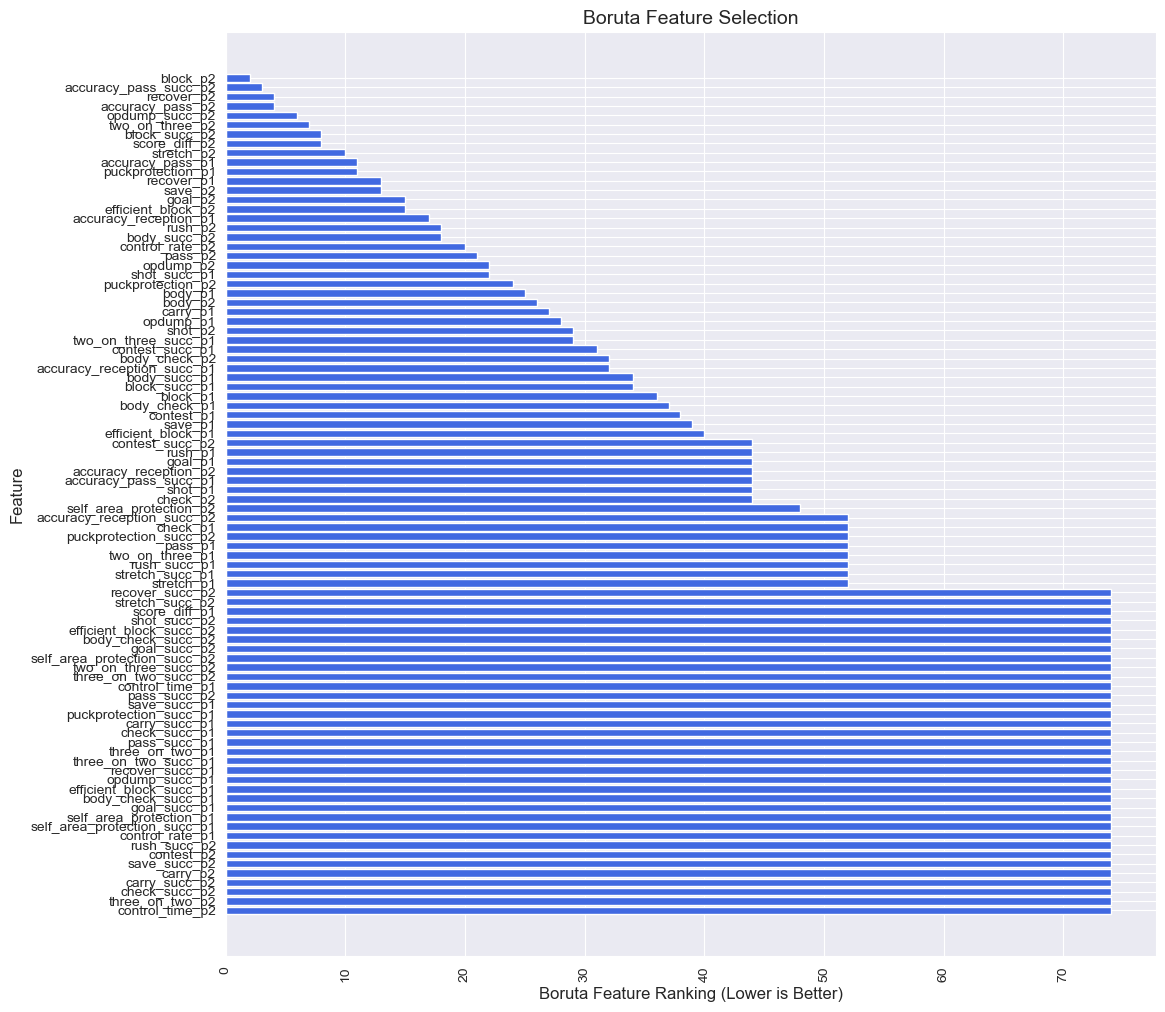

In [6]:
#Boruta算法筛选因子
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric="mlogloss")
# rf = RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=42)


boruta_selector = BorutaPy(xgb_clf, n_estimators="auto", verbose=2, random_state=42)
boruta_selector.fit(X_train, y_train)
# 5. 获取被选中的重要特征
selected_features = X.columns[boruta_selector.support_]
print(f"⭐ 选中的重要特征: {selected_features.tolist()}")

# 6. 获取被 Boruta 拒绝的特征
rejected_features = X.columns[boruta_selector.support_ == False]
#print(f"🚫 被拒绝的特征: {rejected_features.tolist()}")

# 7. 绘制特征重要性对比
feature_ranks = boruta_selector.ranking_
sorted_idx = np.argsort(feature_ranks)

plt.figure(figsize=(12, 12))
plt.xticks(rotation=90)
plt.barh(X.columns[sorted_idx], feature_ranks[sorted_idx], color="royalblue")
plt.xlabel("Boruta Feature Ranking (Lower is Better)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Boruta Feature Selection", fontsize=14)
plt.gca().invert_yaxis()
plt.show()

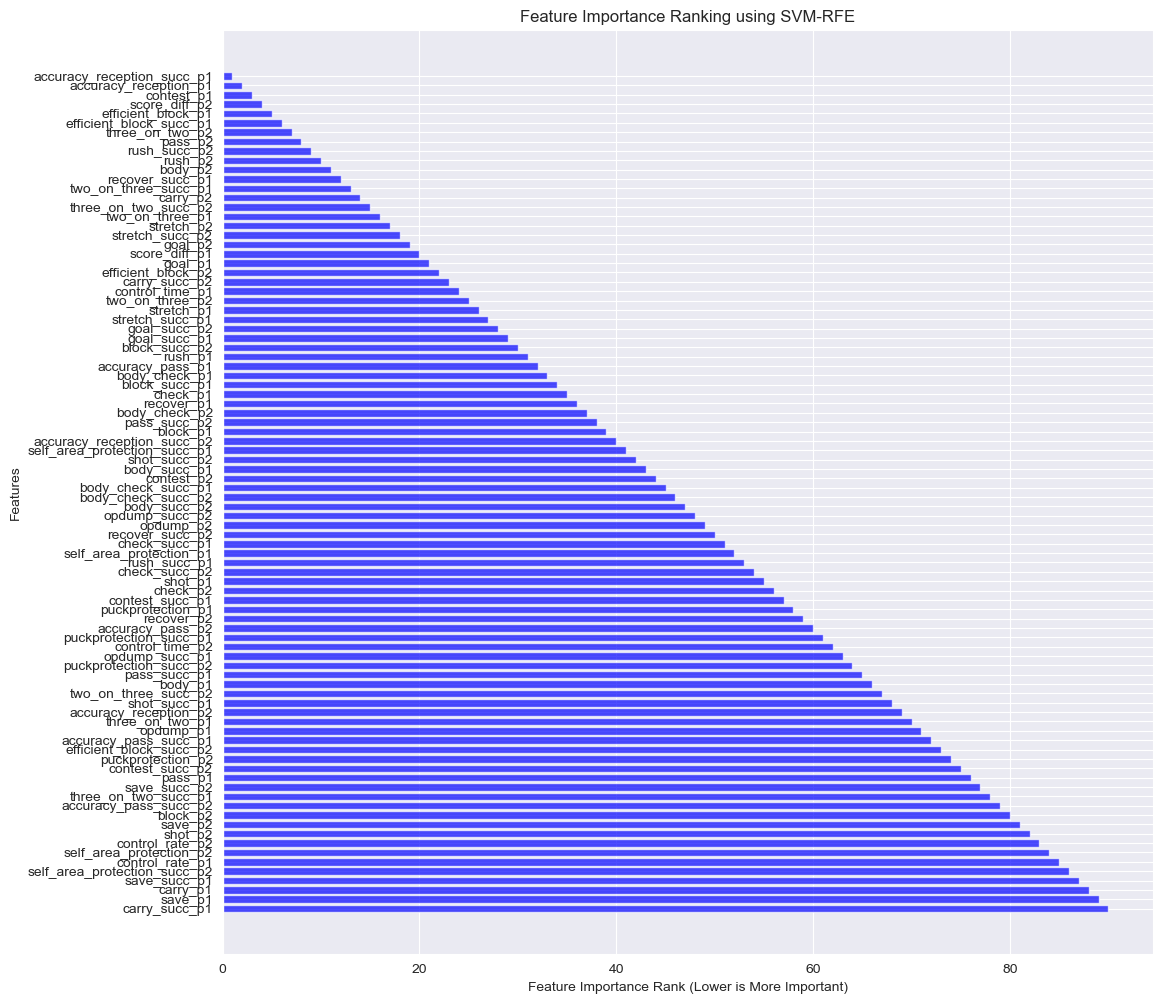

In [7]:
svm = SVC(kernel="linear", C=1)
feature_names =X.columns

# 2️⃣ 进行 RFE 递归特征消除,SVM对尺度敏感
rfe = RFE(estimator=svm, n_features_to_select=1)  # 选到只剩 1 个特征
rfe.fit(X_scaled, y_train)

X_test_selected = rfe.transform(X_test)
# 3️⃣ 获取特征排名
feature_ranking = rfe.ranking_  # 排名，数值越小，代表越重要
sorted_idx = np.argsort(feature_ranking)  # 按排名升序排序
sorted_features = np.array(feature_names)[sorted_idx]

# 4️⃣ 画出特征重要性
plt.figure(figsize=(12, 12))
plt.barh(sorted_features, feature_ranking[sorted_idx], color="blue", alpha=0.7)
plt.xlabel("Feature Importance Rank (Lower is More Important)",fontsize=10)
plt.ylabel("Features",fontsize=10)
plt.title("Feature Importance Ranking using SVM-RFE")
plt.gca().invert_yaxis()  # 让最重要的特征在最上方
plt.show()

In [8]:
#相对特征再来进行训练

In [9]:
# #单独分析比赛 68819
# games = [64485,64765,68819]
# max_cols = 2 #每行最多显示2张
# num_plots = 2 * len(games)
# rows = (num_plots + max_cols - 1) // max_cols
# cols = min(max_cols, num_plots)
# plt.figure(figsize=(15, rows * 3))
# for j in range(len(games)):
#     gameid  = games[j]
#     game_df = data[data['gameid'] == gameid]
#     teams = game_df['teamid'].unique()
#     for i in range(len(teams)):
#         teamid = teams[i]
#         team_df = game_df[game_df['teamid'] == teamid]
#         res_df = pd.DataFrame()
#         for event in index_definition.STRENGTH_EVENTS:
#             condition = team_df.eval(event)
#             condition_df = team_df[condition]
#             res_df = condition_df if res_df.empty else pd.concat([res_df, condition_df],axis=0)
#         ax = plt.subplot(rows, cols, i + 2*j + 1)
#         plt.subplots_adjust(hspace=1)  # 值在 0 到 1 之间，值越大行间距越大
#        # value_counts = res_df['eventname'].value_counts()
#        # sns.countplot(x='eventname', data=res_df, order=value_counts.index, palette="viridis",ax=ax)
#         value_counts = team_df['eventname'].value_counts()
#         sns.countplot(x='eventname', data=team_df, order=value_counts.index, palette="viridis",ax=ax)
# 
#         # plt.xticks(rotation=70)
#         plt.title('Game {}: Team {}'.format(gameid,teamid))
# 
# plt.show()





In [10]:

# games = [64485, 64765,68819,87906]
# max_cols = 2  #每行最多显示2张
# num_plots = 2 * len(games)
# rows = (num_plots + max_cols - 1) // max_cols
# cols = min(max_cols, num_plots)
# plt.figure(figsize=(15, rows * 3))
# for j in range(len(games)):
#     gameid = games[j]
#     home_control_rate, visit_control_rate, home_max_control_time, visit_max_control_time = common.get_control_rate0(data, gameid)
#     print("主队平均控球时间：" + str(sum(home_max_control_time) / len(home_max_control_time)))
#     print("客队平均控球时间：" + str(sum(visit_max_control_time) / len(visit_max_control_time)))
# 
#     # plt.scatter( x=range(len(home_max_control_time)),y=list(home_max_control_time),marker='o',label='Home Team')
#     # plt.scatter(x=range(len(visit_max_control_time)),y=list(visit_max_control_time),marker='x',label='Visit Team')
#     ax = plt.subplot(rows, cols, j + 1)
#     sns.lineplot(x=range(len(home_max_control_time)), y=list(home_max_control_time), color='r', label='Home Team',
#                  ax=ax)
#     sns.lineplot(x=range(len(visit_max_control_time)), y=list(visit_max_control_time), color='b', label='Visit Team',
#                  ax=ax)
#     plt.legend()
#     plt.title('Game {}'.format(gameid))
# plt.show()
